In [2]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
mpl.rcParams['figure.dpi'] = 175
h = 6.6260755e-27 # Planck's constant [erg] [s]
q = 4.803e-10 # electron charge
m_e = 9.109e-28
m_p = 1.6726e-24
c = 2.998e10
h = 6.626e-27

def power_law(gamma, power, A):
    return A * gamma ** (power)

def eV_e(gamma):
    return (gamma*m_e*c**2) / 1.602e-12

def eV_eps(eps):
    return m_e * c**2 * eps / 1.602e-12

def nu_eps(eps):
    return m_e * c**2 * eps / h

def gamma_e(eV):
    return eV / 511000

def eV_p(freq):
    return 4.1357e-13*freq

def make_odd(num):
    if (num % 2 == 0):
        return num + 1
    else:
        return num
    
colours = [
    "#332288",  # Purple
    "#117733",  # Green
    "#44AA99",  # Teal
    "#88CCEE",  # Sky Blue
    "#CC6677",  # Light Red
    "#AA4499",  # Orchid
    "#882255",  # Maroon
]

vibrant = [
    "#0077BB",  # Blue
    "#33BBEE",  # Cyan
    "#009988",  # Teal
    "#EE7733",  # Orange
    "#CC3311",  # Red
    "#EE3377",  # Magenta
]

# Configure Matplotlib to use Times New Roman for mathtext
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'


In [3]:
def power_law(gamma, power, A):
    return A * gamma ** (power)

# Define the exponential function
def exp_func(gamma, A, b):
    return A * np.exp(b * gamma)


# Function to fit the power law to data
def fit_power_law(gamma_data, y_data):
    # Initial guess for the parameters
    initial_guess = [-1., 1.]
    
    # Fit the curve
    params, params_covariance = curve_fit(power_law, gamma_data, y_data, p0=initial_guess, maxfev=int(1e6))
    
    # Extract the fitted parameters
    fitted_power = params[0]
    fitted_A = params[1]
    
    return fitted_power, fitted_A, params_covariance
def fit_and_plot(x_data, y_data, model="exponential", run_data=None, plot_result=False):
    """
    Fits a model to 2D data and optionally plots the result.

    Parameters:
        x_data (array-like): The x-coordinates of the data.
        y_data (array-like): The y-coordinates of the data.
        model (str): Model to fit ("exponential", "generalized", "power_law").
        plot_result (bool): If True, plots the fitted curve against the data.

    Returns:
        popt (tuple): Optimized parameters for the model.
        pcov (2D array): Covariance matrix of the optimized parameters.
    """
    
    # Define models
    def exponential_model(x, a, b):
        return a * np.exp(b * x)
    
    def generalized_model(x, a, b, c):
        return a * np.exp(b * x) + c
    
    def power_law_model(x, a, b):
        return a * x**b
    
    def power_law_acc(x, a, b=-1-run_data["tau_acc"][0]/run_data["tau_esc"][0]):
        return a * x**b
    
    def cooling(x, C, tau=run_data["tau_esc"][0], S=run_data["S"][0]):
        return C * np.exp(1)**(1 / (S * tau * x)) / x ** 2
        
    # Choose model
    if model == "exponential":
        fit_func = exponential_model
        p0 = [1, 0.1]  # Initial guess
    elif model == "cooling":
        fit_func =  cooling
        p0 = [1]  # Initial guess
    elif model == "power_law_acc":
        p0 = [1]  # Initial guess   
        fit_func = power_law_acc
    elif model == "generalized":
        fit_func = generalized_model
        p0 = [1, 0.1, 0]  # Initial guess
    elif model == "power_law":
        fit_func = power_law_model
        p0 = [1, -1]  # Initial guess
    else:
        raise ValueError("Unsupported model. Choose 'exponential', 'generalized', or 'power_law'.")

    # Perform curve fitting
    popt, pcov = curve_fit(fit_func, x_data, y_data, p0=p0, maxfev=10000)
    print(popt)
    # Plot the result if requested
    if plot_result:
        x_fit = np.linspace(min(x_data), max(x_data), 500)
        y_fit = fit_func(x_fit, *popt)
        plt.plot(x_fit, y_fit, c="grey", alpha=0.42, ls="-", lw=5, zorder=0)

    
    return popt, pcov
def find_powerlaw_transition(x, y, window_length=15, poly_order=2):
    """
    Find the transition point between two power laws in log-log space.
    
    Parameters:
    -----------
    x : array-like
        x-coordinates (e.g., gamma values)
    y : array-like
        y-coordinates (e.g., particle distribution)
    window_length : int, optional
        Window length for Savitzky-Golay filter (must be odd)
    poly_order : int, optional
        Polynomial order for the smoothing filter
        
    Returns:
    --------
    transition_point : float
        x-value where the power law transition occurs
    slopes : tuple
        (slope before transition, slope after transition)
    """
    # Convert to log space
    log_x = np.log10(x)
    log_y = np.log10(y)
    
    # Compute numerical derivative (gradient)
    # First smooth the data to reduce noise
    smooth_log_y = savgol_filter(log_y, window_length, poly_order)
    
    # Calculate gradient using central differences
    gradient = np.gradient(smooth_log_y, log_x)
    
    # Smooth the gradient
    smooth_gradient = savgol_filter(gradient, window_length, poly_order)
    
    # Find where gradient changes most rapidly (second derivative peaks)
    second_derivative = np.abs(np.gradient(smooth_gradient, log_x))
    
    # Find the peak in second derivative
    # Exclude edges to avoid boundary effects
    margin = window_length
    peak_idx = margin + np.argmax(second_derivative[margin:-margin])
    
    # Fit power laws to both regions to get precise slopes
    def power_law(x, alpha, c):
        return c + alpha * x
    
    # Split data at the identified transition point
    split_idx = peak_idx
    
    # Fit before transition
    popt1, _ = curve_fit(power_law, log_x[:split_idx], log_y[:split_idx])
    # Fit after transition
    popt2, _ = curve_fit(power_law, log_x[split_idx:], log_y[split_idx:])
    
    return peak_idx, (popt1[0], popt2[0])

def fit_4th_order(x, y, zorder=0):
    # Fit a 4th order polynomial to the data
    coefficients = np.polyfit(np.log10(x), np.log10(y), 4)
    poly = np.poly1d(coefficients)
    print(np.poly1d(coefficients))
    # Calculate fitted values and errors
    x_fit = np.linspace(min(x), max(x), 100)
    log_y_fit = poly(np.log10(x_fit))
    y_fit = 10**log_y_fit
    # Calculate errors (simplified estimate)
    residuals = np.log10(y) - poly(np.log10(x))
    std_dev = np.std(residuals)
    error_margin = std_dev
    y_fit_lower = 10**(log_y_fit - error_margin)
    y_fit_upper = 10**(log_y_fit + error_margin)
    # Plot the fit and error bands
    plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color='tab:blue', alpha=0.5, label="4th order polynomial fit", zorder=zorder)


## Steady state testing

C:\Users\morga\AppData\Local\Temp\ipykernel_18576\1595222219.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + r"\runs\run_simulation_data.csv", index_col=False)


local: 1.03e+02
katu: 1.04e+02
k/l ratio 1.0108


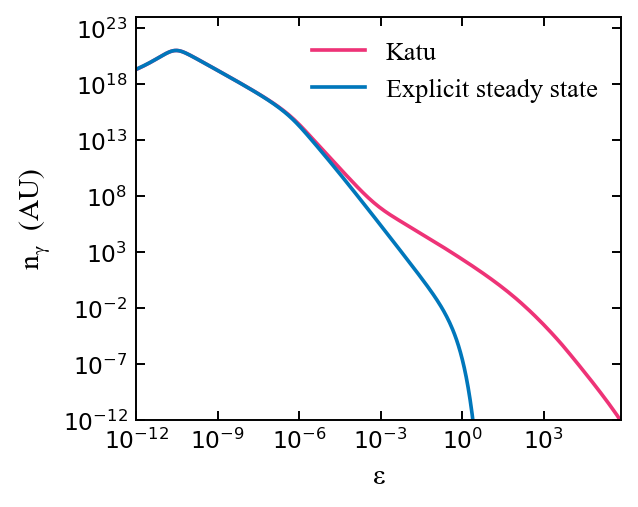

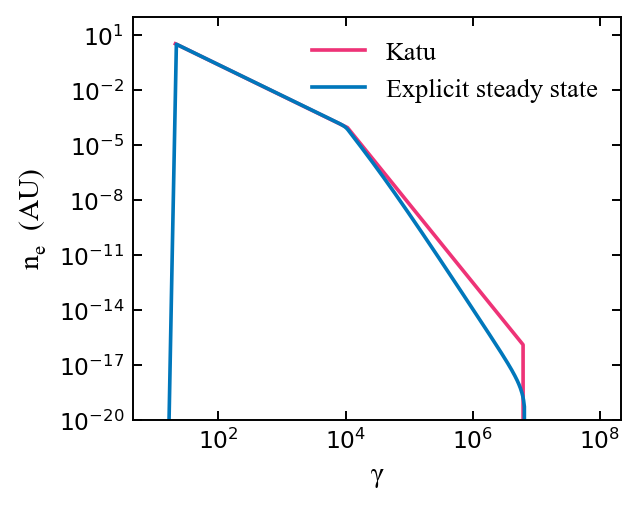

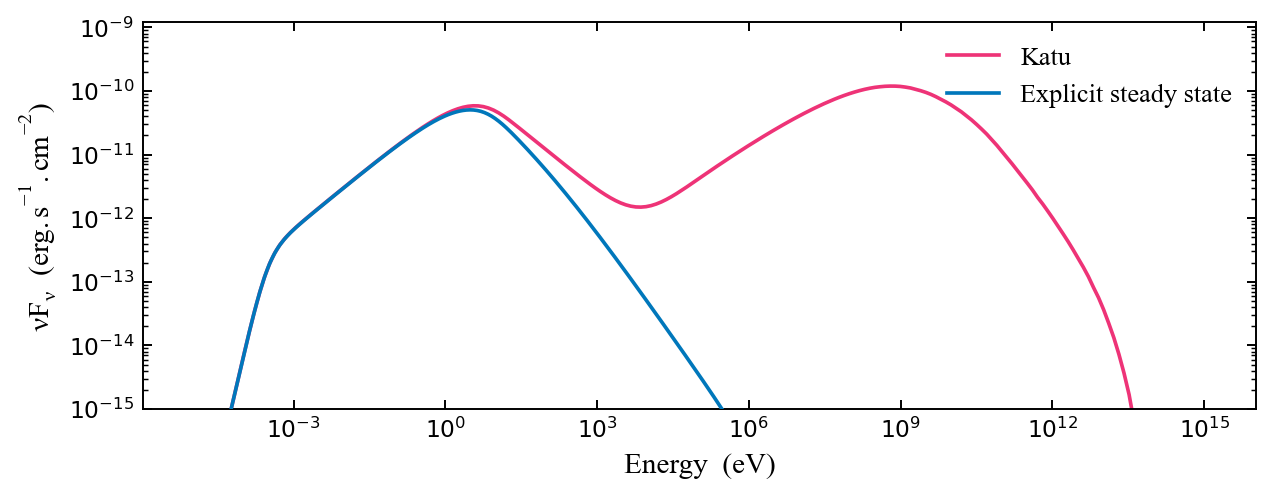

In [32]:
from matplotlib.font_manager import FontProperties

iter = "00016"

path = r"\\wsl$\Ubuntu\home\morgan\katu\data"
katu_photon_data = pd.read_csv(path + r"\photon_data_{}.tsv".format(iter), sep="\t", skiprows=1)
katu_electron_data = pd.read_csv(path + r"\lepton_data_{}.tsv".format(iter), sep="\t", skiprows=2)
katu_photon_data.rename(columns=lambda x: x.lstrip('#').strip(), inplace=True)
katu_electron_data.rename(columns=lambda x: x.lstrip('#').strip(), inplace=True)

path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state"
sim_data = pd.read_csv(path + r"\simulation_data.csv")
run_data = pd.read_csv(path + r"\runs\run_simulation_data.csv", index_col=False)

def calc_flux(run_data, Photon_eps, Photon_n):
    # Constants
    Photon_eps = np.array(Photon_eps)
    Photon_n = np.array(Photon_n)
    nu_flux = np.zeros_like(Photon_eps, dtype=np.float64)
    flux_eps = np.zeros_like(Photon_eps, dtype=np.float64)

    c = 3.0e10  # Speed of light in cm/s
    H0 = 2.27e-18  # Hubble constant in cgs
    m_e = 9.109e-28  # Electron mass in grams
    M_PI = np.pi  # Value of pi
    
    # Calculate the luminosity distance from z << 1 approximation
    dL = c * run_data["z"][0] / H0
    V = 4 / 3 * np.pi * run_data["R"][0] ** 3
    # Pre-factor calculation
    pre_fac = (
        m_e * c**2.0 * run_data["doppler_factor"][0]**4.0 * V /
        (4.0 * M_PI * (1.0 + run_data["z"][0]) * dL**2.0 * run_data["tau_esc"][0])
    )   
    
    # Iterate over the array of intrinsic frequencies
    for i in range(0, len(Photon_eps)):
        # Calculate observed frequency for each intrinsic frequency
        eps_obs = run_data["doppler_factor"][0] * Photon_eps[i] / (1.0 + run_data["z"][0])
        # Calculate the flux in the observer frame
        nu_flux[i] = pre_fac * (Photon_eps[i]**2 * Photon_n[i])
        flux_eps[i] = eps_obs
    return flux_eps, nu_flux

integral = 0
integral2 = 0

for i in range(0, len(sim_data["electron_n"])-1):
    integral += 0.5 * (sim_data["electron_n"][i+1] + sim_data["electron_n"][i]) * (sim_data["gamma"][i+1] - sim_data["gamma"][i])

for i in range(0, len(katu_electron_data["Energy"])-1):
    integral2 += 0.5 * (katu_electron_data["Population"][i+1] + katu_electron_data["Population"][i]) * (katu_electron_data["Energy"][i+1] - katu_electron_data["Energy"][i])

print("local: %.2e" % integral)
print("katu: %.2e" % integral2)
print("k/l ratio", round((integral2 / integral),4))

# Define the fontsize variable
fontsize = 12
legend_font = FontProperties(family='Times New Roman', size=fontsize * 0.9)

# Plot 1
plt.figure(figsize=[3.75, 3])
plt.loglog(katu_photon_data["Energy"], katu_photon_data["Population"],c=vibrant[5], label="Katu")
plt.loglog(sim_data["photon_eps"][1:-1], sim_data["photon_n"][1:-1], c=vibrant[0], label="Explicit steady state")
plt.legend(prop=legend_font, frameon=False)
plt.xlabel(r"$\mathrm{\epsilon}$", fontsize=fontsize, fontdict={'family': 'Times New Roman'})
plt.ylabel(r"$\mathrm{n_\gamma}$  (AU)", fontsize=fontsize, fontdict={'family': 'Times New Roman'})
plt.tick_params(axis='both', which='major', direction="in", labelsize=fontsize*0.8, top=True, right=True)
plt.tick_params(axis='both', which='minor', direction="in", top=True, right=True)
plt.ylim(1e-12,1e24)
plt.xlim(1e-12, 7e5)
plt.tight_layout()
plt.show()

# Plot 2
plt.figure(figsize=[3.75, 3])
plt.loglog(katu_electron_data["Energy"], katu_electron_data["Population"], label="Katu", c = vibrant[5])
plt.loglog(sim_data["gamma"][1:-1], sim_data["electron_n"][1:-1], label="Explicit steady state", c = vibrant[0])
plt.legend(prop=legend_font, frameon=False, loc="upper right")
plt.xlabel(r"$\mathrm{\gamma}$", fontsize=fontsize, fontdict={'family': 'Times New Roman'})
plt.ylabel(r"$\mathrm{n_e}$  (AU)", fontsize=fontsize, fontdict={'family': 'Times New Roman'})
plt.tick_params(axis='both', which='major', direction="in", labelsize=fontsize*0.8, top=True, right=True)
plt.tick_params(axis='both', which='minor', direction="in", top=True, right=True)
plt.ylim(1e-20,1e2)
plt.tight_layout()
plt.show()

# Plot 3
fontsize=12
plt.figure(figsize=[3.72*2, 3])
flux_eps, nu_flux = calc_flux(run_data, katu_photon_data["Energy"], katu_photon_data["Population"])
plt.loglog(eV_eps(flux_eps), nu_flux, label="Katu", c=vibrant[5])
plt.loglog(eV_eps(sim_data["flux_eps"][1:-1]), sim_data["nu_flux"][1:-1], label="Explicit steady state", zorder=3, c=vibrant[0])

plt.legend(prop=legend_font, frameon=False, loc="upper right")

plt.xlabel(r"Energy  (eV)", fontsize=fontsize, fontdict={'family': 'Times New Roman'})
plt.ylabel(r"$\mathrm{\nu F_\nu}$  ($\mathrm{erg }.\mathrm{s}^{-1}.\mathrm{cm}^{-2}$)", fontsize=fontsize, fontdict={'family': 'Times New Roman'})

plt.ylim(1e-15, 1.2e-9)
plt.tight_layout()
plt.tick_params(axis='both', which='major', direction="in", labelsize=fontsize*0.8, top=True, right=True)
plt.tick_params(axis='both', which='minor', direction="in", top=True, right=True)
plt.show()

C:\Users\morga\AppData\Local\Temp\ipykernel_9436\4093725536.py:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + fr"\runs\run_t_acc={multiple}_t_esc.csv",index_col=False)
C:\Users\morga\AppData\Local\Temp\ipykernel_9436\4093725536.py:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + fr"\runs\run_t_acc={multiple}_t_esc.csv",index_col=False)
C:\Users\morga\AppData\Local\Temp\ipykernel_9436\4093725536.py:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + fr"\runs\run_t_acc={multiple}_t_esc.csv",index_col=False)
C:\Users\morga\AppData\Local\Temp\ipykernel_9436\4093725536.py:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of d

[2.29312796e-08]
[1.22470122e-07]
[7.66676189e-07]
[5.54292831e-06]
[0.03275714]


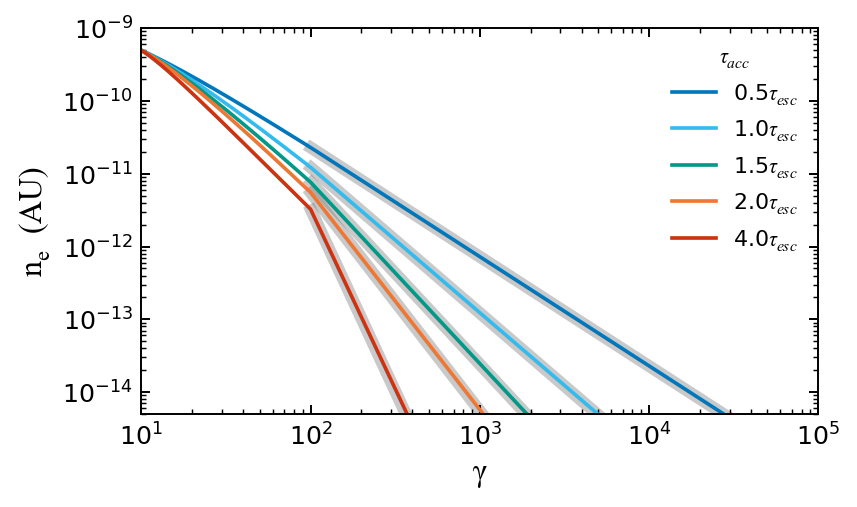

In [43]:
t_esc_multiple = ["0.5","1.0","1.5","2.0","4.0"]
fontsize=13
path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state"
plt.figure(figsize=[5,3])
for multiple, colour in zip(t_esc_multiple, vibrant):
    sim_data = pd.read_csv(path + fr"\t_acc={multiple}_t_esc.csv")
    run_data = pd.read_csv(path + fr"\runs\run_t_acc={multiple}_t_esc.csv",index_col=False)

    sim_data = sim_data[sim_data["electron_n"] > 1e-20]
    plt.loglog(sim_data["gamma"], sim_data["electron_n"],c=colour, label ="{}".format(round(run_data["tau_acc"][0]/run_data["tau_esc"][0], 1)) + "$\\tau_{esc}$")
    steady_state_spd = sim_data["gamma"][sim_data["gamma"] > run_data["inject_min"][0] * 10]
    steady_state_time = sim_data["electron_n"][sim_data["gamma"] > run_data["inject_min"][0] * 10]

    fit_and_plot(steady_state_spd,steady_state_time, "power_law_acc", run_data, True)
    #p, A, param = fit_power_law(steady_state_spd,steady_state_time)
    #plt.plot(steady_state_spd, power_law(steady_state_spd,p,A), "grey", alpha=0.5, lw=5,) #label = f"p = {round(p, 3)}")

#plt.vlines(run_data["inject_max"][0], 1e-14, 1e-9,"black", "dashed", lw=1)
plt.legend(title=r"$\tau_{acc}$", fontsize=fontsize*0.7, title_fontproperties={'family':'Times New Roman', 'size':fontsize * 0.7}, frameon=False)
plt.ylabel(r"$\mathrm{n_e}$  (AU)", fontsize=fontsize, fontdict={'family': 'Times New Roman'})
plt.xlabel(r"$\mathrm{\gamma}$", fontsize=fontsize, fontdict={'family': 'Times New Roman'})

plt.xlim(1e1, 1e5)
plt.ylim(5e-15,1e-9)

plt.tick_params(axis='both', which='major', direction="in", labelsize=fontsize*0.8, top=True, right=True)
plt.tick_params(axis='both', which='minor', direction="in", top=True, right=True)
plt.tight_layout()
plt.show()

C:\Users\morga\AppData\Local\Temp\ipykernel_18576\4036316305.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + rf"\runs\run_{file}", index_col=False)
C:\Users\morga\AppData\Local\Temp\ipykernel_18576\4036316305.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + rf"\runs\run_{file}", index_col=False)
C:\Users\morga\AppData\Local\Temp\ipykernel_18576\4036316305.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + rf"\runs\run_{file}", index_col=False)
C:\Users\morga\AppData\Local\Temp\ipykernel_18576\4036316305.py:13: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_cs

[658203.56718291]
[3.07608568e-06]
[4.75678868e-08]
[6.6867636e-09]
[2.68933405e-09]
[1.4615033e-09]


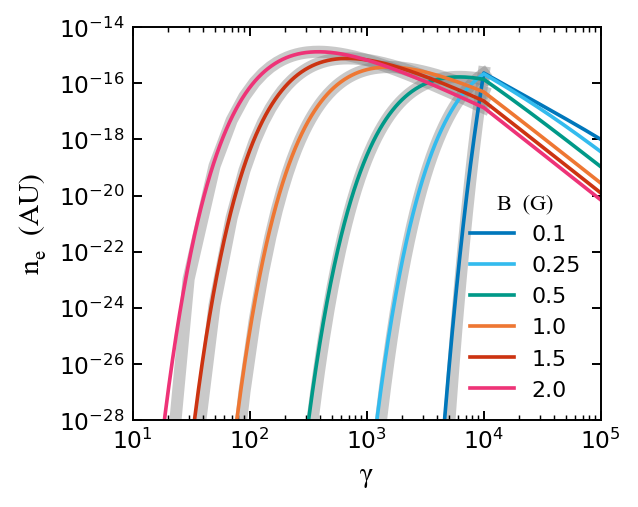

In [24]:
files = ["B0.10.csv","B0.25.csv","B0.50.csv","B1.00.csv","B1.50.csv","B2.00.csv"]
names = ["0.1", "0.25", "0.5", "1.0", "1.5", "2.0"]
#names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]
path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state"
import matplotlib.pyplot as plt
import pandas as pd

# Define the fontsize variable
fontsize = 12
plt.figure(figsize=[3.75, 3])
for file, name, colour in zip(files, names, vibrant): 
    sim_data = pd.read_csv(path + rf"\{file}")
    run_data = pd.read_csv(path + rf"\runs\run_{file}", index_col=False)

    sim_data = sim_data.fillna(0)

    cooling_data = sim_data[sim_data["electron_n"] != 0]
    cooling_data = cooling_data[cooling_data["gamma"] <= run_data["inject_min"].values[0]]
    
    fit_and_plot(cooling_data["gamma"], cooling_data["electron_n"], "cooling", run_data, True)
    plt.plot(sim_data["gamma"], sim_data["electron_n"], c= colour, label=name)

# Set labels with fontsize
plt.ylabel(r"$\mathrm{n_e}$  (AU)", fontsize=fontsize, fontdict={'family': 'Times New Roman'})
plt.xlabel(r"$\mathrm{\gamma}$", fontsize=fontsize, fontdict={'family': 'Times New Roman'})

# Set scale and limits
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e1, 1e5)
plt.ylim(1e-28, 1e-14)

# Add vertical line
#plt.vlines(1e4, 1e-28, 1e-7, color="black", linestyle="dashed")

# Customize legend with fontsize
plt.legend(fontsize=fontsize*0.76,
           title_fontproperties={'family':'Times New Roman', 'size':fontsize * 0.76}, 
           title = "B  (G)", 
           frameon=False,
           loc="lower right")

# Customize ticks with fontsize
plt.tick_params(axis='both', which='major', direction="in", labelsize=fontsize*0.8, top=True, right=True)
plt.tick_params(axis='both', which='minor', direction="in", top=True, right=True)
# Adjust layout and display grid
plt.tight_layout()
#plt.grid()

# Display the plot
plt.show()


C:\Users\morga\AppData\Local\Temp\ipykernel_18576\1304215126.py:12: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + r"\runs\run_{}".format(file), index_col=False)
C:\Users\morga\AppData\Local\Temp\ipykernel_18576\1304215126.py:12: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + r"\runs\run_{}".format(file), index_col=False)


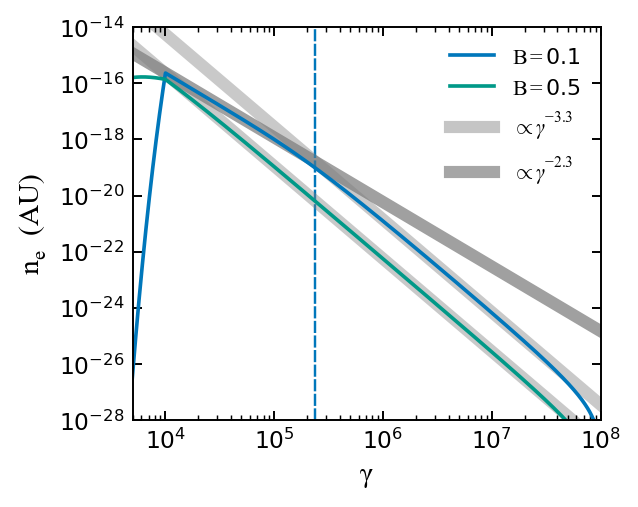

In [23]:
from matplotlib.font_manager import FontProperties
path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state"
files = ["B0.10.csv", "B0.50.csv"]
names = ["B=0.1", "B=0.5"]

fs=8
fontsize=12
lw = 5
plt.figure(figsize=[3.75,3])
for file, name, colour in zip(files, names, [vibrant[0],vibrant[2]]): 
    sim_data=pd.read_csv(path + r"\{}".format(file))
    run_data = pd.read_csv(path + r"\runs\run_{}".format(file), index_col=False)
    plt.plot(sim_data["gamma"], sim_data["electron_n"], label=name, c=colour)
    C = run_data["Q_e0"][0] * run_data["norm"][0]
    plt.plot(sim_data["gamma"], 
            power_law(np.array(sim_data["gamma"]), -run_data["inject_p"][0]-1, C / (run_data["S"][0]*(1-run_data["inject_p"][0]))), 
            c= "grey", 
            alpha=0.42, 
            ls="-",
            lw=lw,
            zorder=1,
    )
    if name != names[0]:
        continue
    plt.plot(sim_data["gamma"], 
            power_law(np.array(sim_data["gamma"]), -run_data["inject_p"][0], C * run_data["tau_esc"][0]), 
            c = "grey",
            alpha=0.75, 
            ls="-",
            lw=lw,
            zorder=0,
    )
    gamma_c = 1 / (run_data["S"][0] * run_data["tau_esc"][0] * (1-run_data["inject_p"][0]))
    plt.vlines(gamma_c, 1e-32, 2e12, colour, (0, (5, 1)),lw=1,zorder=0,)

plt.plot(np.NaN, np.NaN, ls=(0, (5, 1)), lw=1, c = vibrant[0], label = "$\gamma_c$")
plt.plot(np.NaN, np.NaN, c= "grey", alpha=0.45, ls="-",lw=lw,
        label = rf"$\propto\gamma^{{{-run_data['inject_p'][0]-1}}}$",
        zorder=1,
)

plt.plot(np.NaN, np.NaN,c = "grey", alpha=0.7, ls="-",lw=lw,
        label = rf"$\propto\gamma^{{{-run_data['inject_p'][0]}}}$",
        zorder=0,
)

plt.yscale("log")
plt.xscale("log")
# Customize legend with fontsize

plt.ylabel(r"$\mathrm{n_e}$  (AU)", fontsize=fontsize, fontdict={'family': 'Times New Roman'})
plt.xlabel(r"$\mathrm{\gamma}$", fontsize=fontsize, fontdict={'family': 'Times New Roman'})
# Creating legend with mixed fonts

# Customizing legend fonts
times_new_roman = FontProperties(family='Times New Roman', size=12)

# Manually setting legend labels
handles = [
    plt.Line2D([0], [0], color=vibrant[0], lw=1.5),
    plt.Line2D([0], [0], color=vibrant[2], lw=1.5),
    plt.Line2D([0], [0], color="grey", lw=5, alpha=0.45),
    plt.Line2D([0], [0], color="grey", lw=5, alpha=0.7),
]
labels = [
    r"$\mathdefault{\mathrm{B=}}$0.1",  # "B=" in Times New Roman, 0.1 in default font
    r"$\mathdefault{\mathrm{B=}}$0.5",
    rf"$\propto\gamma^{{{-run_data['inject_p'][0]-1}}}$",
    rf"$\propto\gamma^{{{-run_data['inject_p'][0]}}}$",
]

# Adding legend to the plot
plt.legend(handles, labels, fontsize=fontsize*0.76, frameon=False)
# Customize ticks with fontsize
plt.tick_params(axis='both', which='major', direction="in", labelsize=fontsize*0.8, top=True, right=True)
plt.tick_params(axis='both', which='minor', direction="in", top=True, right=True)
plt.xlim(5e3, 1e8)
plt.ylim(1e-28, 1e-14)
plt.tight_layout()


C:\Users\morga\AppData\Local\Temp\ipykernel_9436\3952780605.py:15: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + rf"\runs\run_{file}", index_col=False)


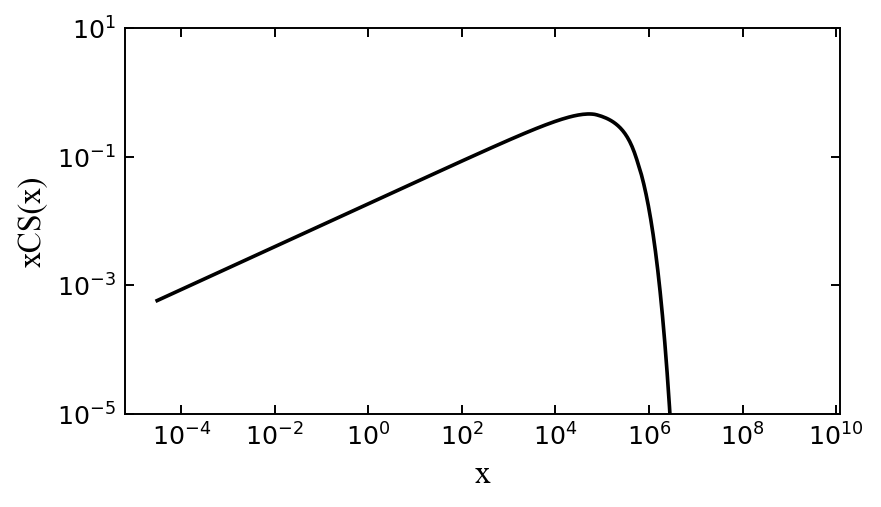

In [41]:
# Define the nu_crit function
def nu_crit(gamma, B):
    return (gamma * gamma * B * 3. * q) / (4. * np.pi * m_e * c)

path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state"
file = "simulation_data.csv"

# Define the fontsize variable
fontsize = 13

# Create the figure
plt.figure(figsize=[5, 3])

# Load the data
run_data = pd.read_csv(path + rf"\runs\run_{file}", index_col=False)
sim_data = pd.read_csv(path + rf"\{file}")

# Calculate x
x = 1e17 / nu_crit(sim_data["gamma"][1:-2], run_data["B"][0])

# Plot the data
plt.plot(x, sim_data["xCS"][1:-2], "k")

# Set labels with Times New Roman font
plt.ylabel("xCS(x)", fontsize=fontsize, fontdict={'family': 'Times New Roman'})
plt.xlabel("x", fontsize=fontsize, fontdict={'family': 'Times New Roman'})

# Set scale and limits
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-5, 1e1)

# Customize ticks
plt.minorticks_off()
plt.tick_params(axis='both', direction='in', labelsize=fontsize*0.8, top=True, right=True)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()



## Implicit Solving

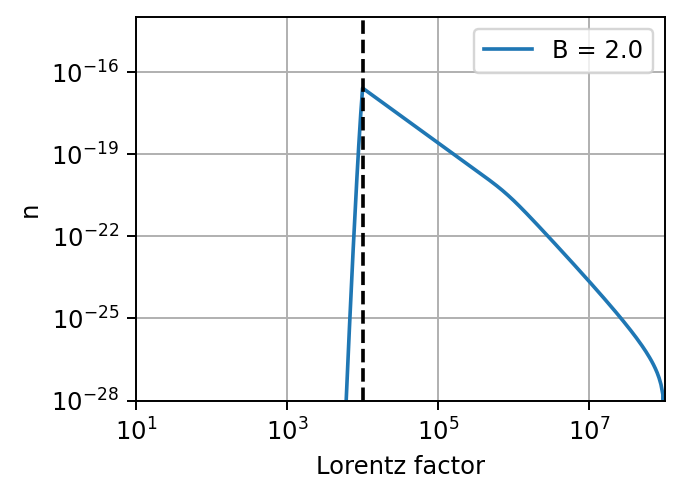

In [7]:

plt.figure(figsize=[4,3])
run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\implicit_solve\{}".format("simulation_data.csv"),)
plt.plot(run_data["gamma"], run_data["electron_n"], label=name)
plt.ylabel("n")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Lorentz factor")
plt.xlim(1e1,1e8)
plt.ylim(1e-28,1e-14)
plt.vlines(1e4, 1e-28, 1e-7, "black", "dashed")
plt.legend()
plt.tight_layout()
plt.grid()

# Timing

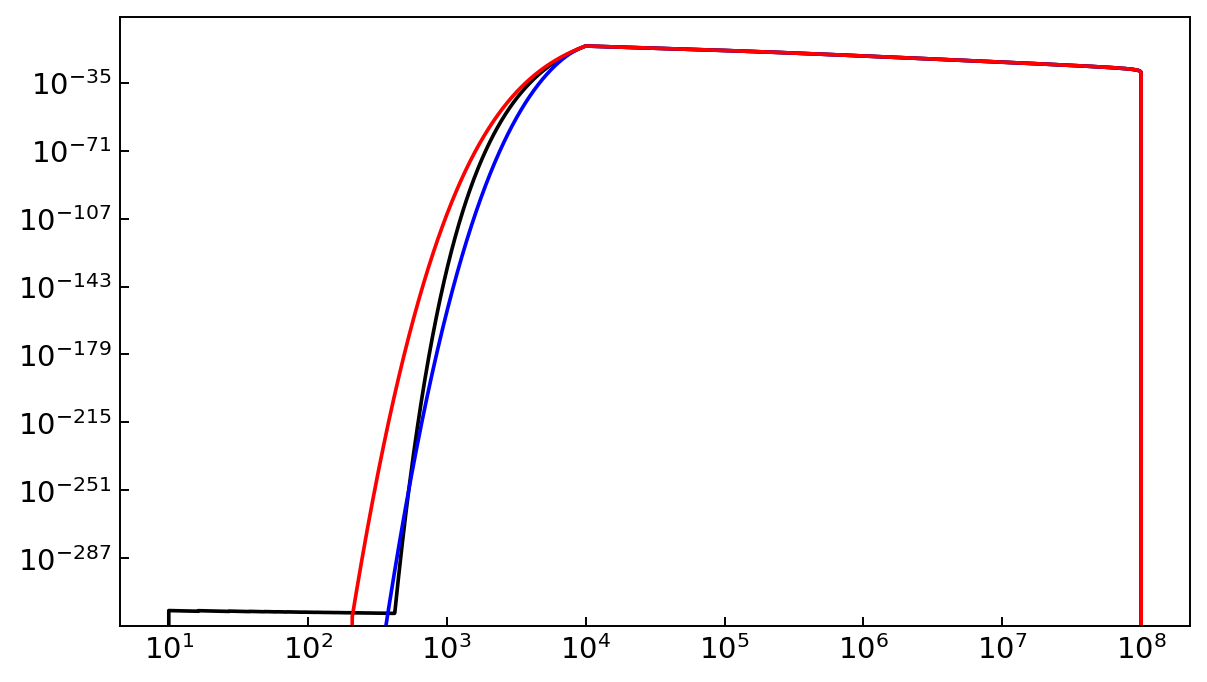

In [33]:
# Define the nu_crit function
def nu_crit(gamma, B):
    return (gamma * gamma * B * 3. * q) / (4. * np.pi * m_e * c)

path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\time_testing\implicit_solve"
file = "1_samples_per_dec_512.csv"

# Define the fontsize variable
fontsize = 16

# Create the figure
plt.figure(figsize=[7, 4])

# Load the data
run_data = pd.read_csv(path + rf"\runs\run_{file}", index_col=False)
sim_data = pd.read_csv(path + rf"\{file}")

# Calculate x
x = 1e17 / nu_crit(sim_data["gamma"][1:-2], run_data["B"][0])

# Plot the data
plt.plot(sim_data["gamma"], sim_data["theory"], "k")
plt.plot(sim_data["gamma"], sim_data["electron_n"], "b")

path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\time_testing\steady_state"

sim_data = pd.read_csv(path + rf"\{file}")
#
plt.plot(sim_data["gamma"], sim_data["electron_n"], "r")

# Set labels with Times New Roman font
plt.ylabel("", fontsize=fontsize, fontdict={'family': 'Times New Roman'})
plt.xlabel("", fontsize=fontsize, fontdict={'family': 'Times New Roman'})

# Set scale and limits
plt.yscale("log")
plt.xscale("log")
#plt.ylim(1e-28, 1e-14)

# Customize ticks
plt.minorticks_off()
plt.tick_params(axis='both', direction='in', labelsize=fontsize*0.75)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()



In [35]:
spds = [int(2**(n/2)) for n in range(8, 32)]
files = [f"samples_per_dec_{spd}.csv" for spd in spds]
steady_state_spd = []
steady_state_time = []
steady_state_std_log = []  # New list for standard deviations
steady_state_std = []
implicit_spd = []
implicit_time = []
implicit_std_log = []  # New list for standard deviations
implicit_std = []
column = "solve_time"
tests = 50
path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\time_testing"

for mainfile, name in zip(files, spds):
    temp_values = []
    temp2_values = []

    for iter in range(1, tests+1):
        file = f"{iter}_{mainfile}"
        run_data = pd.read_csv(path + r"\steady_state\runs\run_{}".format(file), index_col=False)
        temp_values.append(run_data[column][0])
        run_data2 = pd.read_csv(path + r"\implicit_solve\runs\run_{}".format(file),index_col=False)
        temp2_values.append(run_data2[column][0])
    steady_state_spd.append(run_data["array_len"][0])
    implicit_spd.append(run_data2["array_len"][0])
    
    steady_state_time.append(np.mean(temp_values))
    implicit_time.append(np.mean(temp2_values))
    
    steady_state_std_log.append(np.std(np.log10(temp_values)))
    steady_state_std.append(np.std(temp_values))
    implicit_std_log.append(np.std(np.log10(temp2_values)))
    implicit_std.append(np.std(temp2_values))

steady_state_spd = np.array(steady_state_spd)
steady_state_time = np.array(steady_state_time)
steady_state_std_log = np.array(steady_state_std_log)
implicit_spd = np.array(implicit_spd)
implicit_time = np.array(implicit_time)
implicit_std_log = np.array(implicit_std_log)


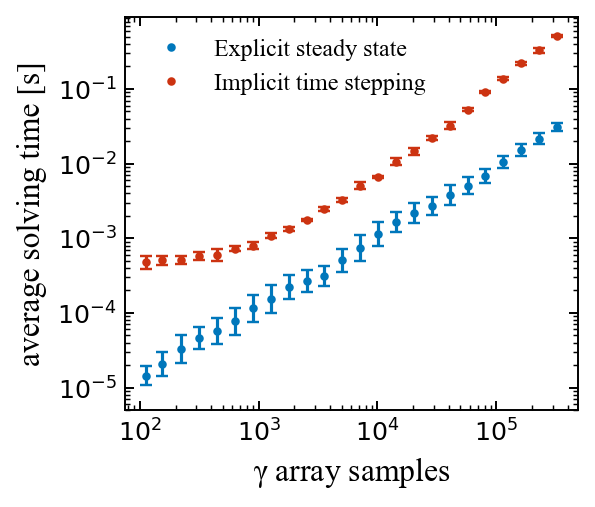

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Define the fontsize variable
fontsize = 13

plt.figure(figsize=[3.5, 3])


# Convert logarithmic errors to asymmetric errors in normal space
steady_state_lower_err = steady_state_time - 10**(np.log10(steady_state_time) - steady_state_std_log)
steady_state_upper_err = 10**(np.log10(steady_state_time) + steady_state_std_log) - steady_state_time
implicit_lower_err = implicit_time - 10**(np.log10(implicit_time) - implicit_std_log)
implicit_upper_err = 10**(np.log10(implicit_time) + implicit_std_log) - implicit_time

# Plot data with asymmetric error bars
plt.plot(steady_state_spd, steady_state_time, ".", ms=5,label="Explicit steady state",
          c=vibrant[0])
plt.errorbar(steady_state_spd, steady_state_time, 
             yerr=[steady_state_lower_err, steady_state_upper_err], 
             fmt='none', ecolor=vibrant[0], capsize=2.5, lw=1.3)

plt.plot(implicit_spd, implicit_time, ".", label="Implicit time stepping", ms=5, c=vibrant[4])
plt.errorbar(implicit_spd, implicit_time, 
             yerr=[implicit_lower_err, implicit_upper_err], 
             fmt='none', ecolor=vibrant[4], capsize=2.5, lw=1.3)

# Set labels with fontsize
if column == "sim_time":
    plt.ylabel(f"Sim time (inc writing) [s]", fontsize=fontsize, fontdict={'family': 'Times New Roman'})
else:
    plt.ylabel(f"average solving time [s]", fontsize=fontsize, fontdict={'family': 'Times New Roman'})

plt.xlabel("$\mathrm{\gamma}$ array samples", fontsize=fontsize, fontdict={'family': 'Times New Roman'})

# Customize ticks with fontsize
plt.tick_params(axis='both', which='major', direction="in", labelsize=fontsize*0.8, top=True, right=True)
plt.tick_params(axis='both', which='minor', direction="in", top=True, right=True)

# Add legend with fontsize
legend_font = FontProperties(family='Times New Roman', size=fontsize * 0.76)
plt.legend(prop=legend_font, frameon=False)

# Set plot scales and grid
plt.yscale("log")
plt.xscale("log")
plt.ylim(5e-6,)
plt.tight_layout()

# Display the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[4.308131845707603e-06, 7.838367176906169e-06, 1.4077442949626896e-05, 1.6448720314966754e-05, 2.441285726825109e-05, 3.4750683446516555e-05, 5.036903810874295e-05, 7.428716174413988e-05, 8.33637547139043e-05, 0.00010190974241945664, 0.00010970404003499598, 0.00018652967592316244, 0.00030474463801681567, 0.00039081126084083095, 0.00047564378478016505, 0.0006384830337604906, 0.0008047121830816283, 0.0012848877898089, 0.001488072461810916, 0.0019950583731810955, 0.0020741467439889592, 0.0034199322871074508, 0.003933010826377166, 0.004025812431249126]


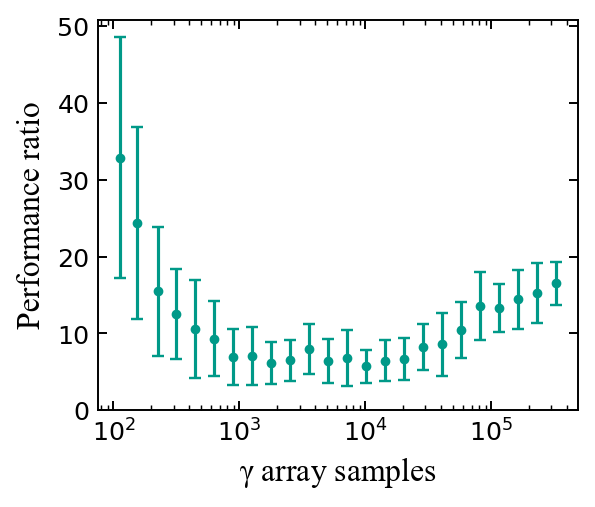

In [115]:
plt.figure(figsize=[3.5, 3])
steady_state_perc_err = steady_state_std / steady_state_time
implicit_perc_err = implicit_std / implicit_time
print(steady_state_std)
ratio = implicit_time/steady_state_time
ratio_err = ratio * (steady_state_perc_err+implicit_perc_err)

plt.plot(steady_state_spd, ratio, ".", c=vibrant[2])
plt.errorbar(steady_state_spd, ratio, yerr=ratio_err, fmt='none', ecolor=vibrant[2], capsize=2.5, lw=1.3)


# Set labels with fontsize
plt.ylabel(r"Performance ratio", fontsize=fontsize, fontdict={'family': 'Times New Roman'})

plt.xlabel("$\mathrm{\gamma}$ array samples", fontsize=fontsize, fontdict={'family': 'Times New Roman'})

# Customize ticks with fontsize
plt.tick_params(axis='both', which='major', direction="in", labelsize=fontsize*0.8, top=True, right=True)
plt.tick_params(axis='both', which='minor', direction="in", top=True, right=True)

# Add legend with fontsize
legend_font = FontProperties(family='Times New Roman', size=fontsize * 0.8)
plt.legend(prop=legend_font, frameon=False)

# Set plot scales and grid
#plt.yscale("log")
plt.xscale("log")
plt.ylim(0,)
plt.tight_layout()

# Display the plot
plt.show()

In [96]:
min(ratio)

5.7190999549284065

In [97]:
max(ratio)

32.897222222222226